### Imports

In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
import os
from scipy.optimize import leastsq


# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath


# Firefly client imports
from IPython.display import IFrame

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [4]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False
isr_config.doSaturationInterpolation=False

### Construct the `IsrTask` with the above configuration

In [5]:
isr = IsrTask(config=isr_config)

### Setup firefly to do image visualization

In [6]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

In [7]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})
gain = {}; signal = {}
exp_time = {}

i = 1
for visit1, visit2 in zip(visits[:-1:2], visits[1::2]): # loop over pairs of images
    # Get ISR data for first image
    dId = {'visit': visit1, 'detector': 2}
    raw1 = butler.get('raw', **dId)
    bias1 = butler.get('bias', **dId)
    time1 = raw1.getInfo().getVisitInfo().getExposureTime()
    
    # Get ISR data for second image
    dId = {'visit': visit2, 'detector': 2}
    raw2 = butler.get('raw', **dId)
    bias2 = butler.get('bias', **dId)
    time2 = raw2.getInfo().getVisitInfo().getExposureTime()
    if abs(time1 - time2) > 0.01:
        "Mismatched exptimes"
        continue
    
    # run ISR on both images
    result1 = isr.run(raw1, bias=bias1)
    result2 = isr.run(raw2, bias=bias2)
    
    detector = result1.exposure.getDetector()
    amp = detector[3]
#    print(amp)

    sub_im1 = result1.exposure.getMaskedImage()[amp.getBBox()]
    #arr1 = sub_im1.getImage().getArray()
    sub_im2 = result2.exposure.getMaskedImage()[amp.getBBox()]
    #arr2 = sub_im2.getImage().getArray()
    
    # From RHL, 1/g = <(I1-I2)**2/(I1+I2)>
    diff_im = sub_im1.clone()
    diff_im -= sub_im2
    
    sum_im = sub_im1.clone()
    sum_im += sub_im2
    
    diff_im *= diff_im
    diff_im /= sum_im
    
    stats = afwMath.makeStatistics(sum_im, afwMath.MEDIAN | afwMath.MEAN)
#    stats = afwMath.makeStatistics(diff_im, afwMath.MEDIAN | afwMath.MEAN)
    # Compute gain for this amp.
#    gain[visit1] = 1/stats.getValue(afwMath.MEAN)
    signal[visit1] = stats.getValue(afwMath.MEAN)/2.
    exp_time[visit1] = time1
#    print("visit %i,%i -- %i of %i -- gain=%f, exposure time(s)=%f"%(visit1, visit2, i, len(visits)/2, gain[visit1], exp_time[visit1], ))
    print("visit %i,%i -- %i of %i -- signal=%f, exposure time(s)=%f"%(visit1, visit2, i, len(visits)/2, signal[visit1], exp_time[visit1], ))
    i += 1

visit 258339739,258339769 -- 1 of 39 -- signal=91.484621, exposure time(s)=0.088000
visit 258339807,258339839 -- 2 of 39 -- signal=121.203339, exposure time(s)=0.115000
visit 258339875,258339908 -- 3 of 39 -- signal=179.841217, exposure time(s)=0.160000
visit 258339945,258339976 -- 4 of 39 -- signal=237.546025, exposure time(s)=0.213000
visit 258340014,258340047 -- 5 of 39 -- signal=326.918155, exposure time(s)=0.284000
visit 258340086,258340120 -- 6 of 39 -- signal=565.082648, exposure time(s)=0.498000
visit 258340159,258340176 -- 7 of 39 -- signal=770.203536, exposure time(s)=0.667000
visit 258340202,258340220 -- 8 of 39 -- signal=1033.644838, exposure time(s)=0.889000
visit 258340244,258340265 -- 9 of 39 -- signal=1354.054096, exposure time(s)=1.156000
visit 258340290,258340314 -- 10 of 39 -- signal=1893.189540, exposure time(s)=1.601000
visit 258340341,258340363 -- 11 of 39 -- signal=2448.622750, exposure time(s)=2.135000
visit 258340392,258340416 -- 12 of 39 -- signal=3330.415949,

In [ ]:
afw_display.mtv(sub_im1) # display an example image

In [8]:
visit_keys = exp_time.keys()
x = [exp_time[visit] for visit in visit_keys]
#y = [gain[visit] for visit in visit_keys]
y = [signal[visit] for visit in visit_keys]

In [33]:
def linear(x, params):
    (a, b) = params
#    res =  a*x + b
    res =  a*x
    return res

def linear_fit(params, x, y):
    fit = linear( x, params )
    return (fit - y)

In [61]:
fit = leastsq(linear_fit, [1000.,0.], args=(numpy.array(x[0:37]), numpy.array(y[0:37])))
fit1 = leastsq(linear_fit, [1000.,0.], args=(numpy.array(x[0:33]), numpy.array(y[0:33]))) 

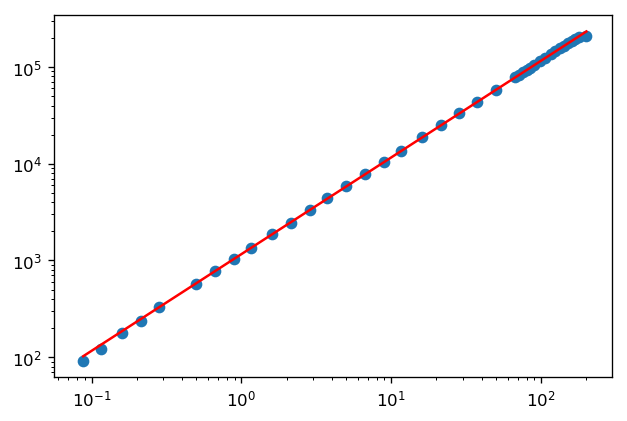

In [52]:
plt.scatter(x, y)
plt.plot(numpy.array(x), linear(numpy.array(x), fit[0]), c='r')
#plt.ylim(0, 2500)
plt.xscale('log')
plt.yscale('log')

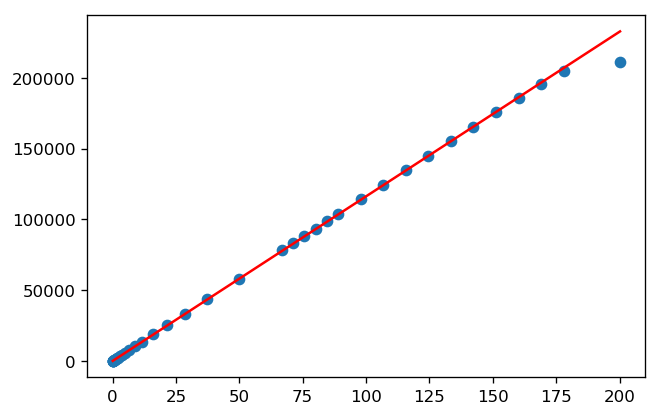

In [53]:
plt.scatter(numpy.array(x), numpy.array(y))
plt.plot(numpy.array(x), linear(numpy.array(x), fit[0]), c='r')

(-1000.0, 1000)

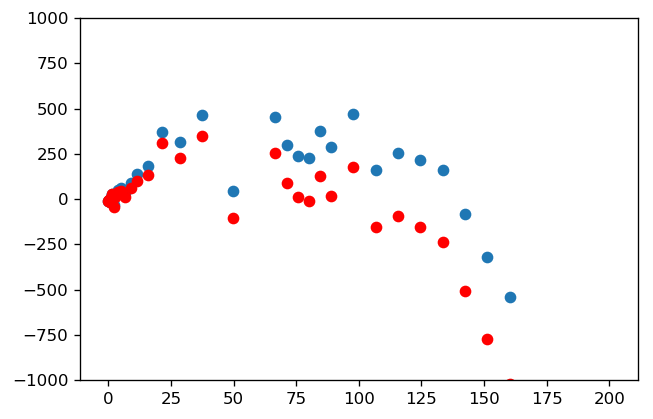

In [62]:
plt.scatter(numpy.array(x), -linear_fit(fit[0], numpy.array(x), numpy.array(y)))
plt.scatter(numpy.array(x), -linear_fit(fit1[0], numpy.array(x), numpy.array(y)), c='r')
#plt.plot(numpy.array(x), linear(numpy.array(x), fit[0]), c='r')
plt.ylim(-1000., 1000)
#plt.xscale('log')
#plt.yscale('log')

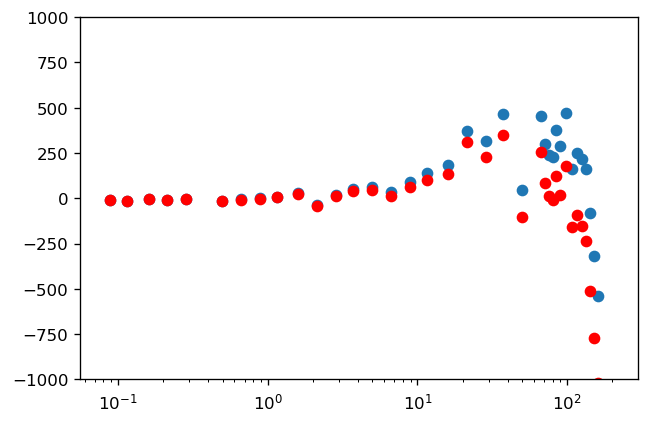

In [63]:
plt.scatter(numpy.array(x), -linear_fit(fit[0], numpy.array(x), numpy.array(y)))
plt.scatter(numpy.array(x), -linear_fit(fit1[0], numpy.array(x), numpy.array(y)), c ='r')
plt.ylim(-1000., 1000)
plt.xscale('log')
#plt.yscale('log')